In [1]:
import os
os.chdir('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.utils.utils import read_trial_json, read_image
import json
import seaborn as sns

def normalize_activations(row):
    """Normalize activations for each neuron"""
    activations = {}
    for key, values in row['neuron_activations'].items():
        values = np.array(values)
        normalized = values / np.sum(values)
        activations[key] = normalized.tolist()
    return activations

def calculate_activation_score(normalized_activations):
    """Calculate score based on activation distribution"""
    scores = []
    for neuron_acts in normalized_activations.values():
        # Calculate ratio between highest activation (should be first image) and mean of others
        target_activation = neuron_acts[0]
        foil_activations = neuron_acts[1:]
        score = target_activation / (np.mean(foil_activations) + 1e-6)  # avoid division by zero
        scores.append(score)
    return np.mean(scores)  # average across all neurons


def find_row_in_results_board(pred_path, overall_acc_csv):
    """Find the matching row in the overall accuracy csv file"""
    # Extract directory path from pred_path
    pred_dir = './'+'/'.join(pred_path.split('/')[:-1])
    df_overall_acc = pd.read_csv(overall_acc_csv)
    df_single_exp = df_overall_acc[df_overall_acc['results_dir'] == pred_dir]
    if len(df_single_exp) == 0:
        raise ValueError(f"No matching results found for prediction directory: {pred_dir}")
    return df_single_exp

def get_args(results_dir):
    """
    Read args.json from results directory and return batch size
    """
    args_path = f"{results_dir}/args.json"
    with open(args_path, 'r') as f:
        args = json.load(f)
    return args

def analyze_predictions(pred_path, overall_acc_csv):
    """
    Analyze predictions and return top 5 correct and bottom 5 incorrect predictions based on activation scores
    """
    # Load predictions
    predictions = pd.read_csv(pred_path)
    
    # Convert string representations back to Python objects
    predictions['neuron_activations'] = predictions['neuron_activations'].apply(eval)
    predictions['categories'] = predictions['categories'].apply(eval)
    predictions['selected_neurons'] = predictions['selected_neurons'].apply(eval)
    
    # Load trial path from CSV
    df_single_exp = find_row_in_results_board(pred_path, overall_acc_csv)
    trial_path = df_single_exp.iloc[0]['trial_path']
    results_dir = df_single_exp.iloc[0]['results_dir']
    
    args = get_args(results_dir)
    
    # Load original trials
    trials = read_trial_json(trial_path)
    
    # Process predictions
    correct_results = []
    incorrect_results = []
    
    for idx, pred in predictions.iterrows():
        norm_activations = normalize_activations(pred)
        score = calculate_activation_score(norm_activations)
        result = {
            'batch_idx': pred['batch_idx'],
            'data_idx': pred['data_idx'],
            'score': score,
            'neuron': pred['selected_neurons'],
            'activations': norm_activations,
            'categories': pred['categories'],
            'is_correct': pred['is_correct']
        }
        
        if pred['is_correct']:
            correct_results.append(result)
        else:
            incorrect_results.append(result)
    
    # Sort results by score
    correct_results.sort(key=lambda x: x['score'], reverse=True)  # Higher score is better
    incorrect_results.sort(key=lambda x: x['score'])  # Lower score indicates worse performance
    
    return correct_results, incorrect_results, trials, args  # Return top  correct and bottom  incorrect


/home/xueyi/.conda/envs/prob_cvcl/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pred_path = "experiments/trials/neurons/appendix_4_way/cvcl-resnext_custom_2025-03-30-21-51-59/predictions.csv"
results_board_csv = "experiments/trials/results/appendix_4_way.csv"

correct_results, incorrect_results, trials, args = analyze_predictions(pred_path, results_board_csv)

/tmp/ipykernel_1035215/2748430524.py:16: RuntimeWarning: invalid value encountered in divide
  normalized = values / np.sum(values)


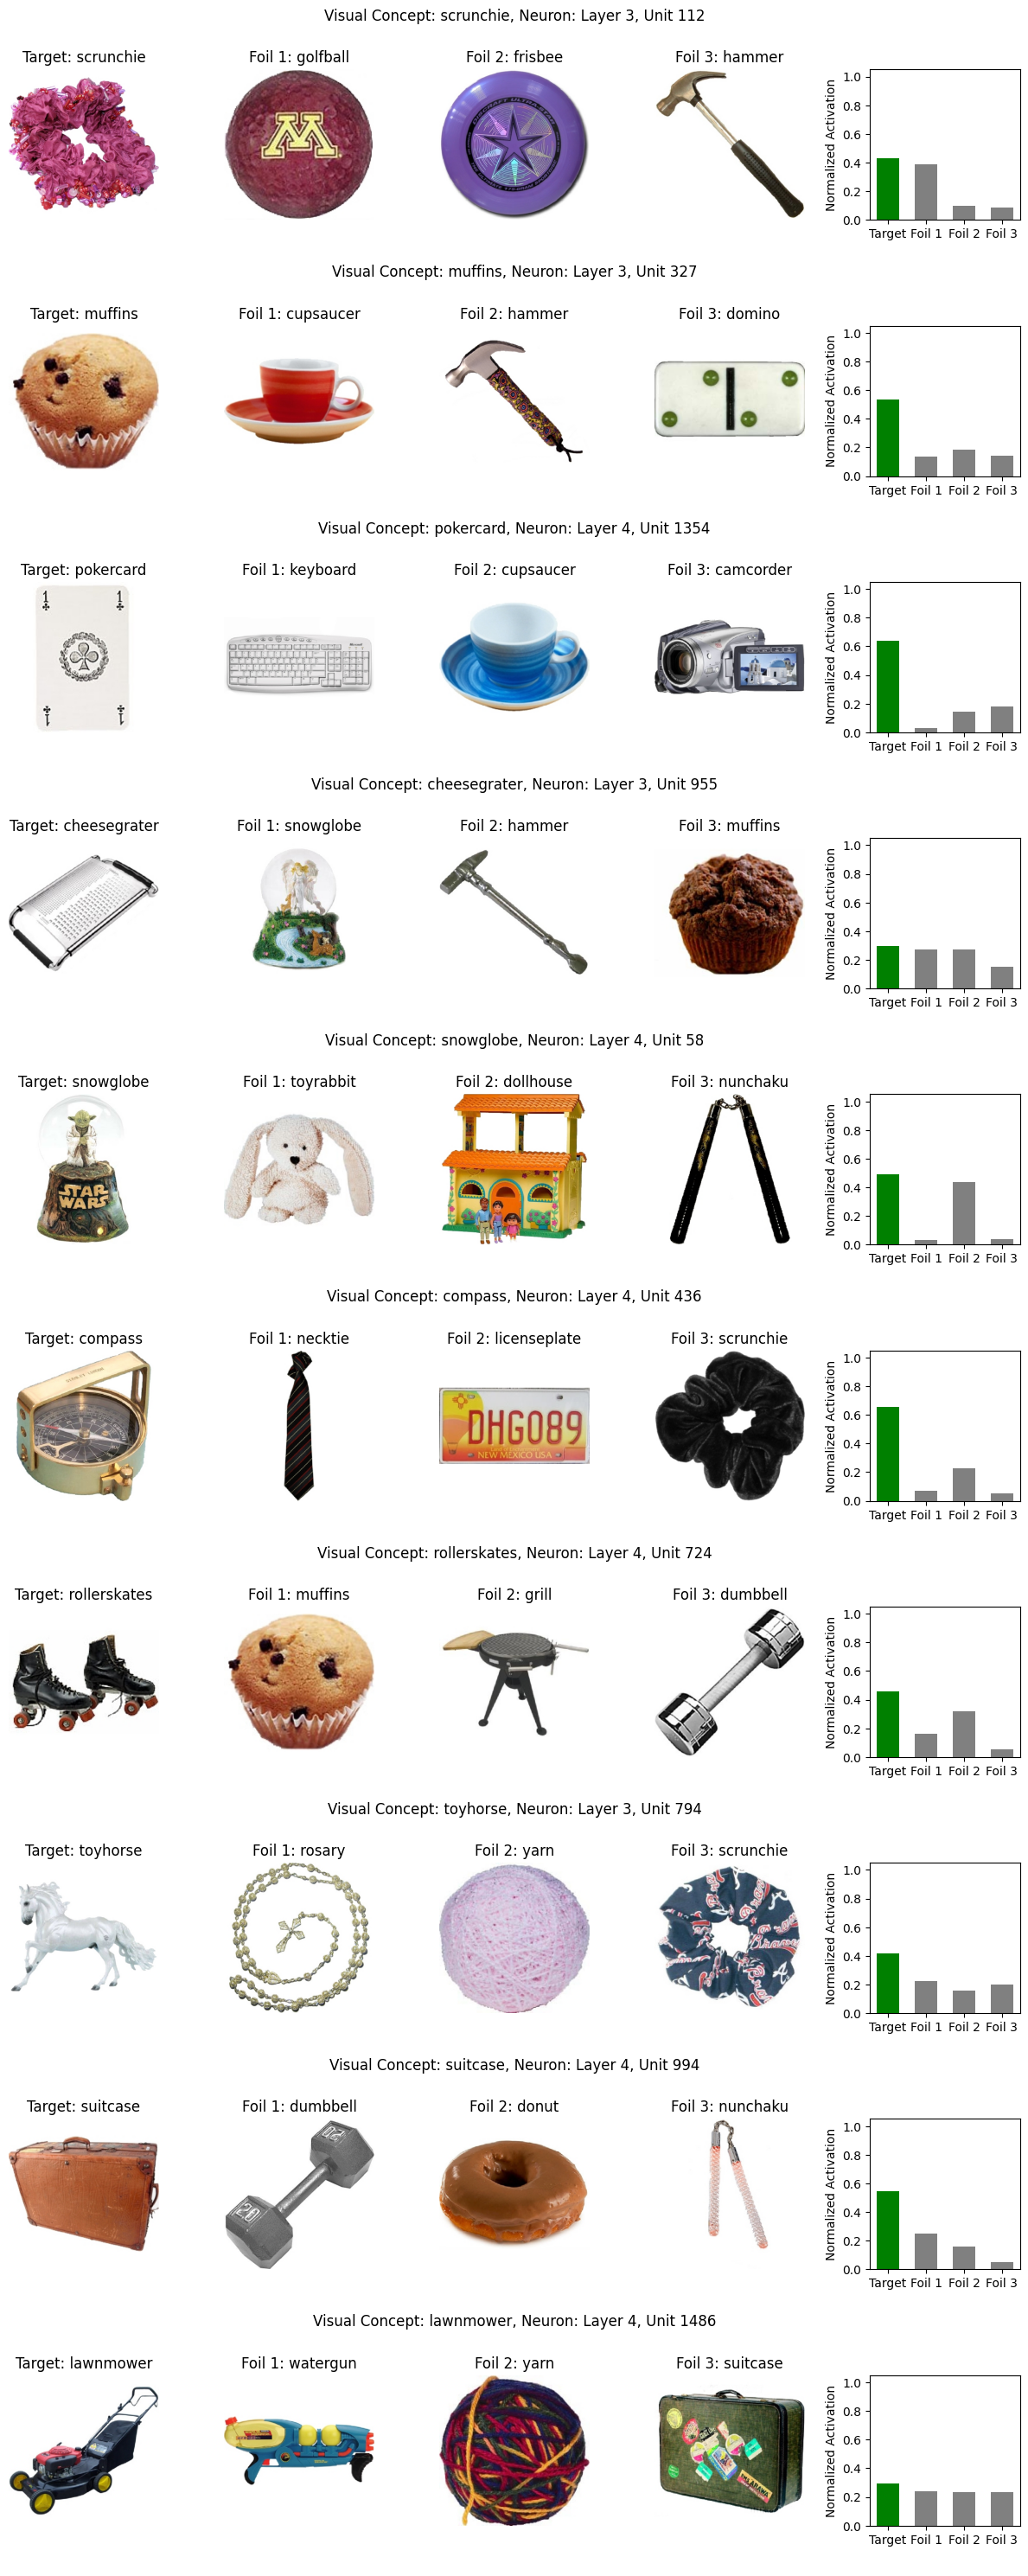

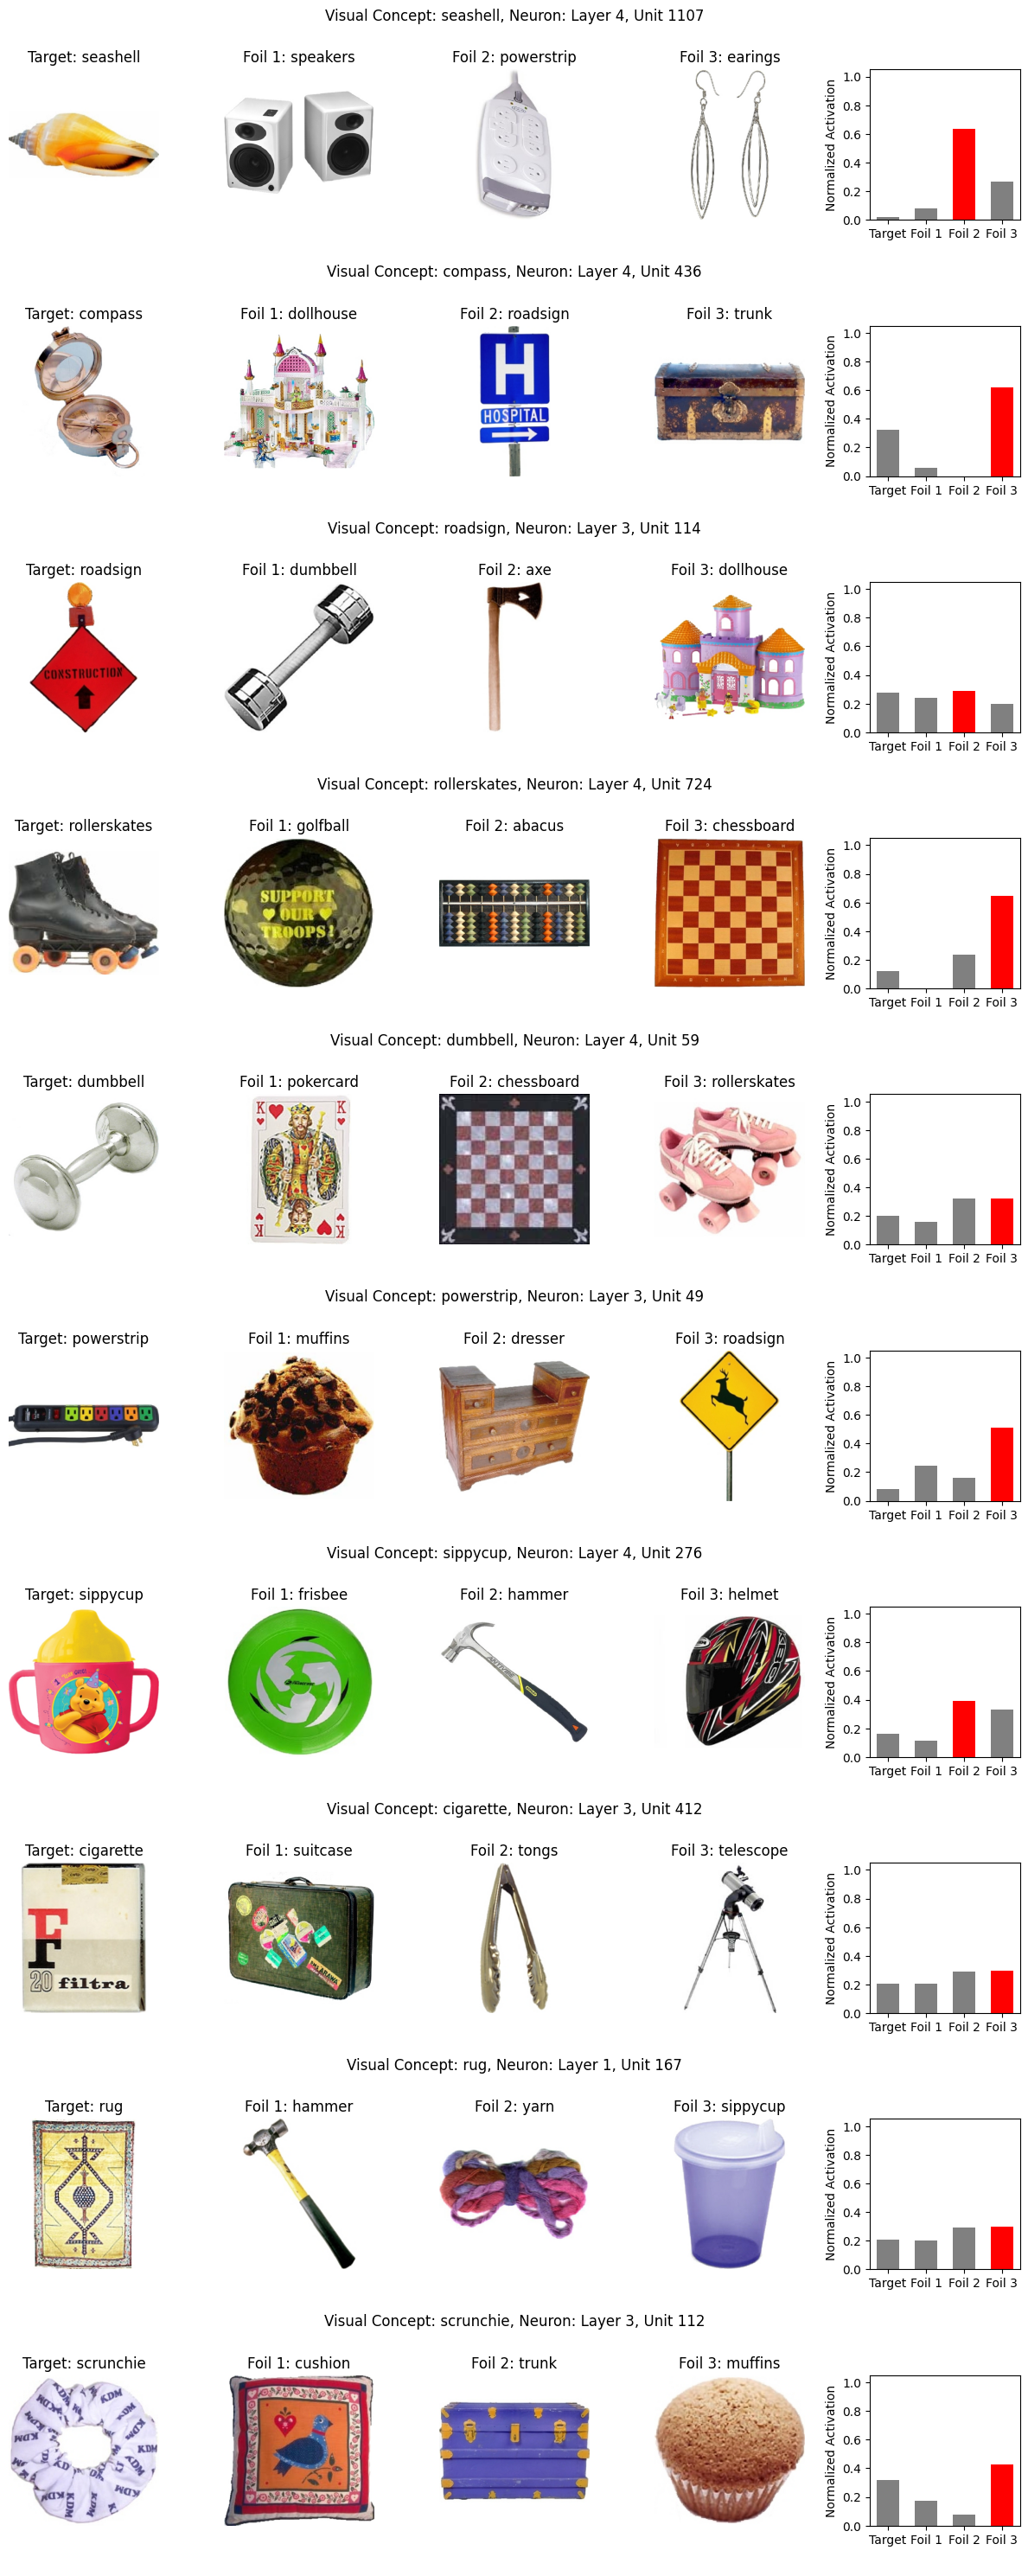

In [4]:
def plot_random_results(results, trials, args, num_samples=10, seed=42, save_path=None):
    """Plot random results in a single column figure and save as PDF"""
    # Set random seed for reproducibility
    np.random.seed(seed)
    
    # Randomly sample from results
    random_indices = np.random.choice(len(results), num_samples, replace=False)
    selected_results = [results[i] for i in random_indices]
    
    # Create a tall figure
    fig = plt.figure(figsize=(12, 3*num_samples))
    
    for idx, result in enumerate(selected_results):
        # Get corresponding trial
        trial_idx = result['batch_idx'] * args['batch_size'] + result['data_idx']
        trial = trials[trial_idx]
        
        # Extract neuron information
        neurons = result['neuron']
        neuron_info = []
        for layer, unit in neurons:
            layer_num = int(''.join(filter(str.isdigit, layer.split('.')[-1])))
            neuron_info.append(f"Layer {layer_num}, Unit {unit}")
        neuron_text = ' | '.join(neuron_info)
        
        # Create a row subplot for the entire group
        row = plt.subplot(num_samples, 1, idx + 1)
        row.set_title(f"Visual Concept: {result['categories'][0]}, Neuron: {neuron_text}", fontsize=12)
        row.axis('off')
        
        # Plot images in subplots
        images = [trial['target_img_filename']] + trial['foil_img_filenames']
        for j, img_path in enumerate(images):
            ax = fig.add_subplot(num_samples, 5, idx*5 + j + 1)
            img = read_image(img_path)
            plt.imshow(img)
            plt.axis('off')
            plt.margins(x=0.01, y=0.01)
            plt.title(f"{'Target' if j==0 else 'Foil '+str(j)}: {result['categories'][j]}")
        
        # Plot activation distribution
        ax = fig.add_subplot(num_samples, 5, idx*5 + 5)
        data = pd.DataFrame(result['activations']).T
        values = data.iloc[0].values

        # Determine bar colors based on target selection
        colors = ['grey'] * len(values)
        if values[0] == max(values):
            colors[0] = 'green'
        else:
            max_foil_idx = np.argmax(values[1:]) + 1
            colors[max_foil_idx] = 'red'

        plt.bar(range(len(values)), values, width=0.6, color=colors)
        ax.set_box_aspect(1)
        plt.ylim(0, 1.05)
        plt.ylabel("Normalized Activation")
        plt.xticks(range(len(values)), ['Target'] + [f'Foil {i+1}' for i in range(len(values)-1)], fontsize=10)

    plt.tight_layout()
    if save_path:
        if not os.path.exists(os.path.dirname(save_path)):
            os.makedirs(os.path.dirname(save_path))
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()

seed = 1
num_samples = 10
# Usage example with seed:
plot_random_results(correct_results, trials, args, num_samples=num_samples, seed=seed)
plot_random_results(incorrect_results, trials, args, num_samples=num_samples, seed=seed)
